# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectFromModel

from tabulate import tabulate
from sklearn.metrics import  mean_absolute_error, mean_squared_error, accuracy_score, precision_score,recall_score
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, plot_roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from boruta import BorutaPy
from imblearn.pipeline import Pipeline

## Part 2: Porto Seguro’s Safe Driver Prediction

In [3]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from time import time

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [4]:
PATH = "./data/"

In [5]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')
insurance_data_test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')
sample_submission = pd.read_csv(os.path.join(PATH, 'porto', 'sample_submission.csv')).set_index('id')


In [6]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [7]:
insurance_data.shape

(595212, 58)

In [8]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [9]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [10]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [13]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

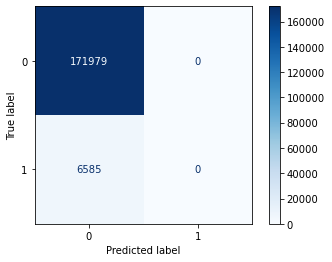

In [14]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

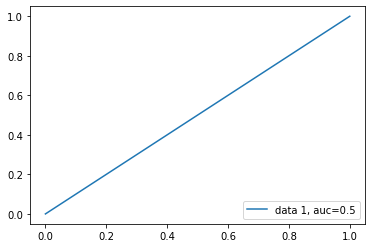

In [15]:
fpr, tpr, _ = roc_curve(y_valid, clf.predict(X_valid))
auc = roc_auc_score(y_valid, clf.predict(X_valid))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [16]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

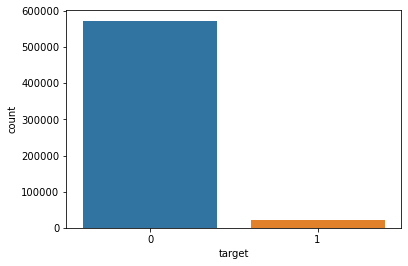

In [17]:
sns.countplot(x='target', data=insurance_data)
plt.show()

In [18]:
insurance_data['target'].value_counts()

0    573518
1     21694
Name: target, dtype: int64

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [19]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

n— Количество объектов в выборке

n_0— Количество объектов класса «0»

n_1— Количество объектов класса «1»

TP— True Positive (верный ответ модели на истинном классе «1» при заданном пороге)

FP— False Positive (неверный ответ модели на истинном классе «0» при заданном пороге)

TPR— True Positive Rate (отношение TP к n_1)

FPR— False Positive Rate (отношение FP к n_0)

i,j— текущий индекс элемента.
$$AUC = \int_{0}^{1} TPR \,dFPR = \frac{1}{n_0 * n_1}\ \int_{0}^{1} TP \,dFP$$

$$ G =  \int_{0}^{1} TPR \,d\frac{TP+FP}{n_0 * n_1}\ -0.5 $$

$$ G_{norm} = \frac{G_{modeled}}{G_{perfect}}$$

$$ G_{norm} = \frac{\int_{0}^{1} TPR \,d\frac{TP+FP}{n_0 * n_1}\ -0.5 }{\int_{0}^{1}  \,d\frac{TP}{n_0 * n_1}\ -0.5 } $$

$$ G_{norm} =  -\int_{0}^{1}d\frac{TP^{2}+FP*TP}{n_0 * n_1}\ + \int_{0}^{1}\,d\frac{(TP+FP)*TP}{n_0 * n_1}\ $$

$$G_{norm} = \int_{0}^{1}\,d\frac{(TP+FP)*TP}{n_0 * n_1}\ +1$$
$$G_{norm} = \frac{1}{n_0 * n_1}\int_{0}^{1}\,d((TP+FP)*TP) +1 = -1 + \frac{2}{n_0 * n_1}\int_{0}^{1}TP\,dFP = 2*AUC -1$$

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

For visualisation other possible metrics are Lift Curve and Cumulative gains chart. Also, Hoover index can be applied for estimation of the problem

Let's calculate the Normalized Gini Coefficient:

In [20]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [21]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [22]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')
insurance_data_test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')
sample_submission = pd.read_csv(os.path.join(PATH, 'porto', 'sample_submission.csv')).set_index('id')

In [23]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [24]:
X.shape

(595212, 57)

In [25]:
y.value_counts()

0    573518
1     21694
Name: target, dtype: int64

In [26]:
labels = X.columns

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 57 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ps_ind_01       595212 non-null  int64  
 1   ps_ind_02_cat   595212 non-null  int64  
 2   ps_ind_03       595212 non-null  int64  
 3   ps_ind_04_cat   595212 non-null  int64  
 4   ps_ind_05_cat   595212 non-null  int64  
 5   ps_ind_06_bin   595212 non-null  int64  
 6   ps_ind_07_bin   595212 non-null  int64  
 7   ps_ind_08_bin   595212 non-null  int64  
 8   ps_ind_09_bin   595212 non-null  int64  
 9   ps_ind_10_bin   595212 non-null  int64  
 10  ps_ind_11_bin   595212 non-null  int64  
 11  ps_ind_12_bin   595212 non-null  int64  
 12  ps_ind_13_bin   595212 non-null  int64  
 13  ps_ind_14       595212 non-null  int64  
 14  ps_ind_15       595212 non-null  int64  
 15  ps_ind_16_bin   595212 non-null  int64  
 16  ps_ind_17_bin   595212 non-null  int64  
 17  ps_ind_18

In [28]:
print('Nan values =', X.isnull().sum().sum())

Nan values = 0


In [29]:
cat_features = [cat for cat in labels if 'cat' in cat]
bin_features = [binl for binl in labels if 'bin' in binl]
cont_features = [col for col in labels if col not in cat_features + bin_features]

In [30]:
print("catergorical:", len(cat_features),'\n', 'binary:', len(bin_features), '\n', 'continuous:', len(cont_features))

catergorical: 14 
 binary: 17 
 continuous: 26


In [31]:
def bar_plot(col, data, hue=None):
    f, ax = plt.subplots(figsize=(12, 5))
    sns.countplot(x = col, hue=hue, data = data)
    plt.show()

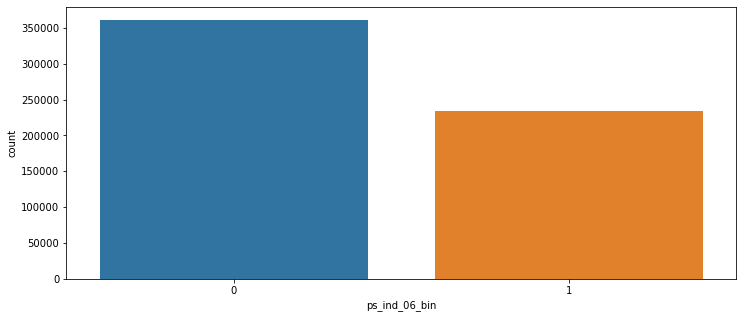

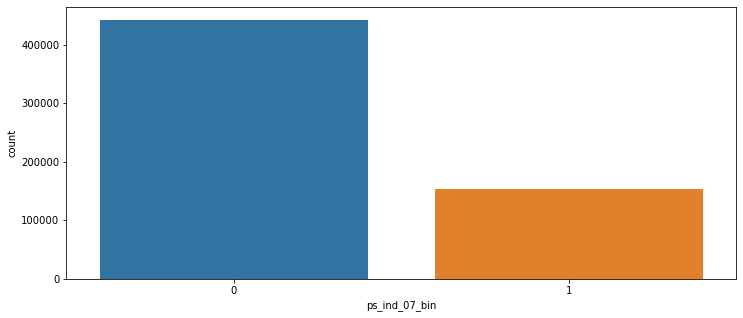

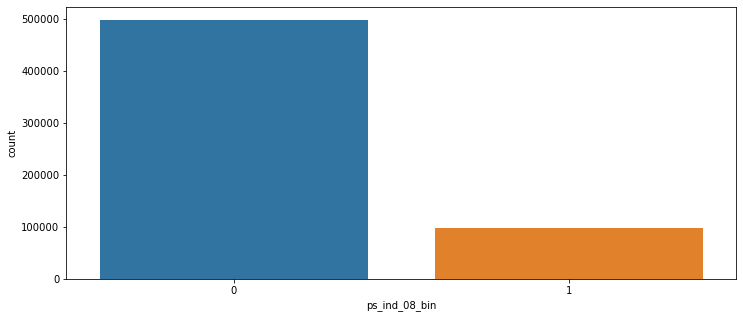

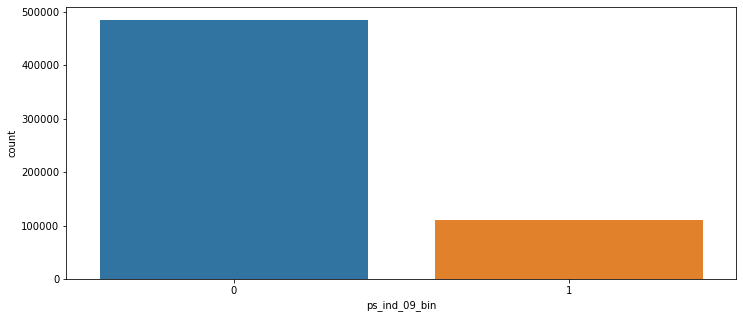

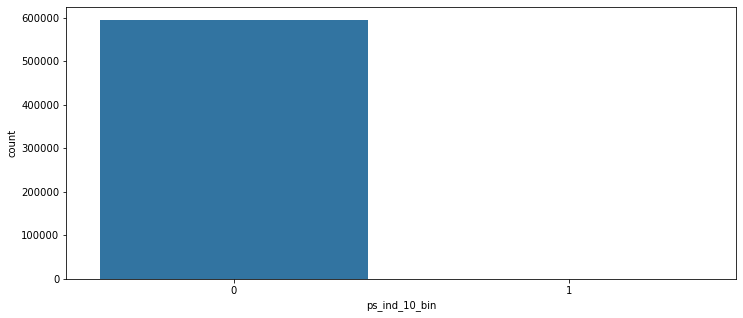

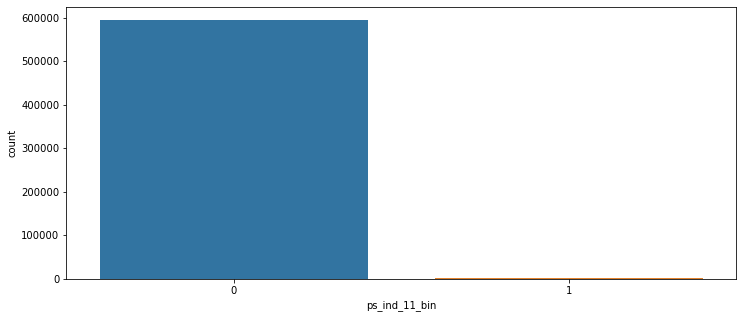

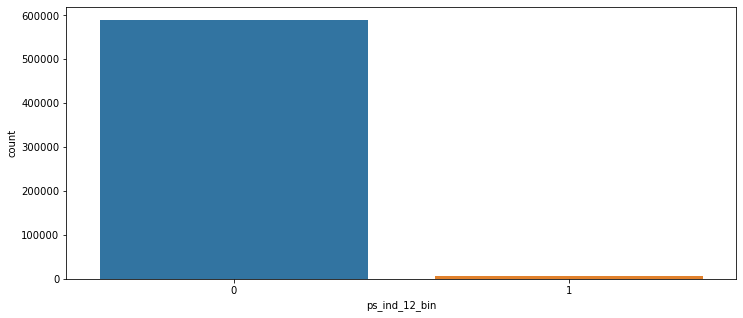

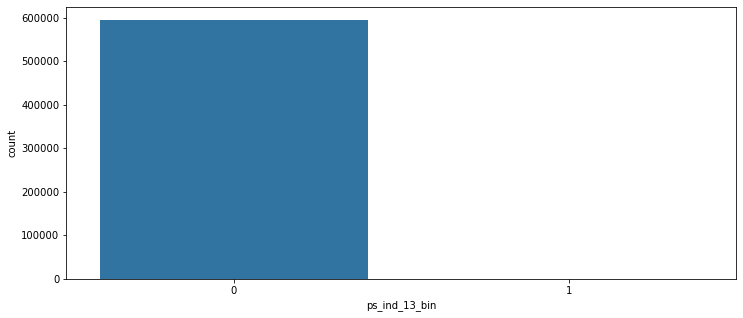

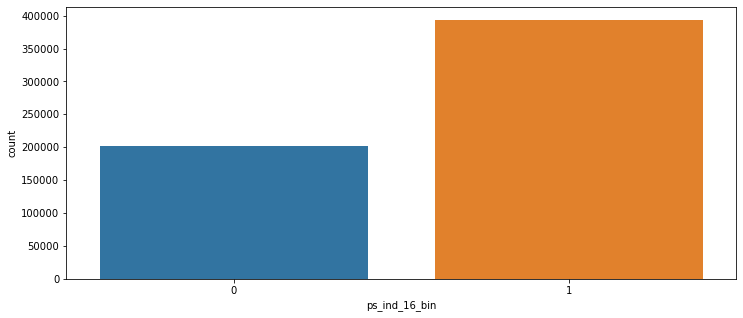

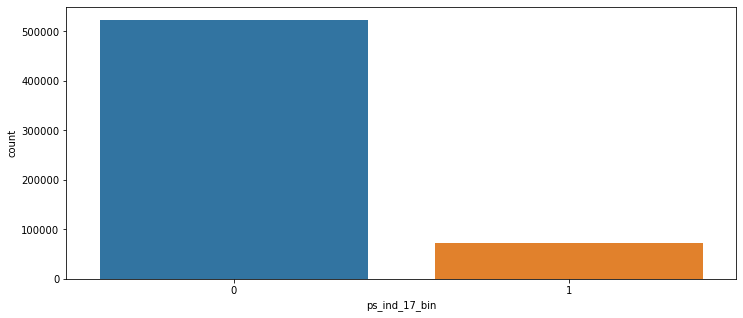

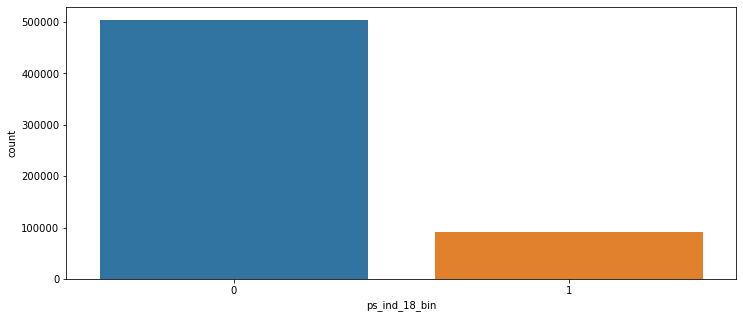

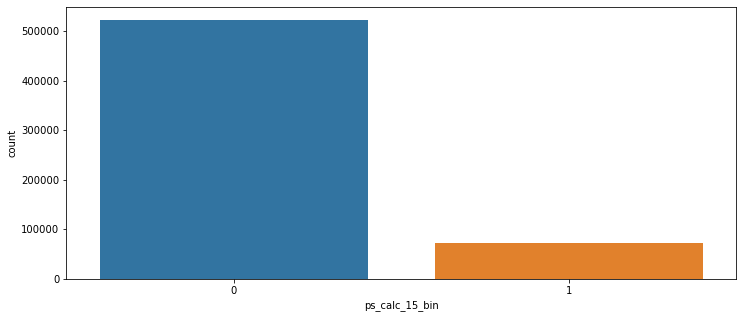

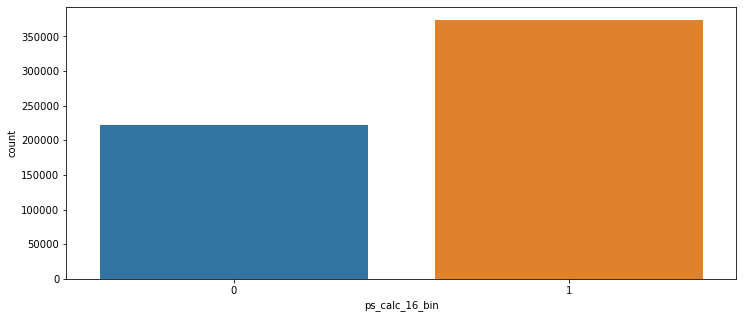

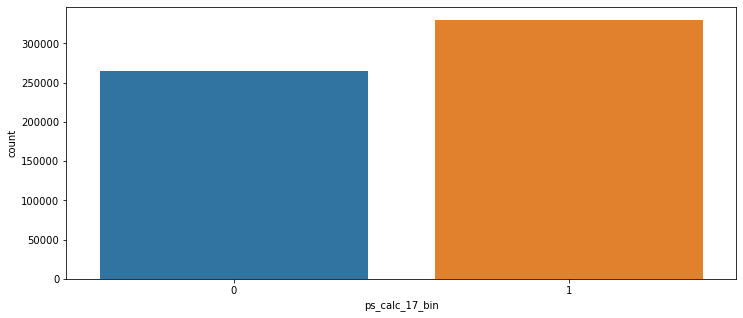

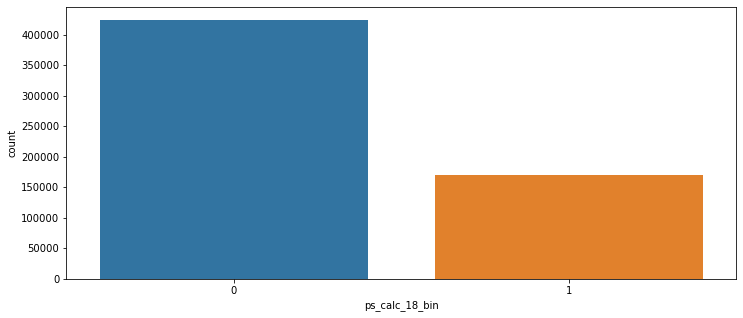

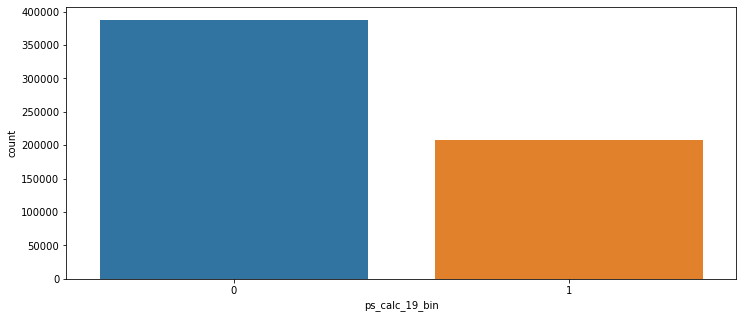

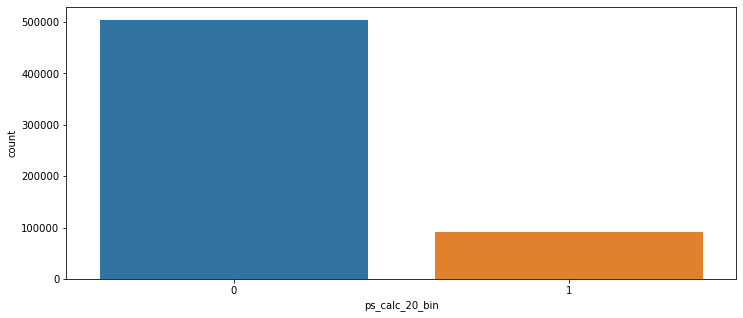

In [32]:
for col in bin_features:
    bar_plot(col, X)

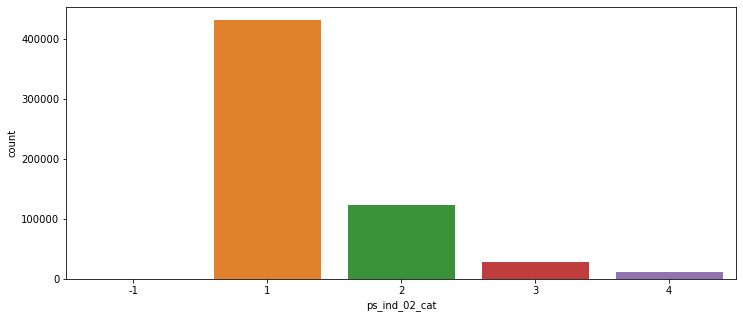

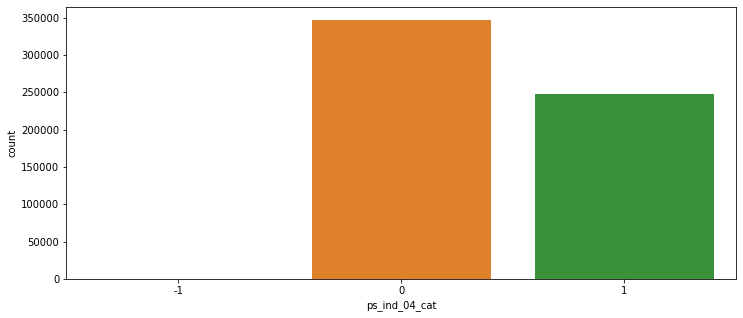

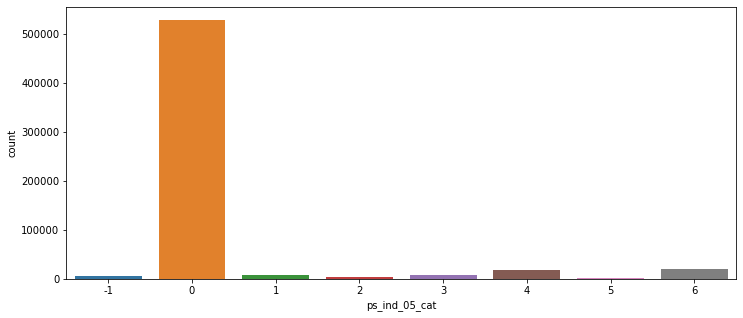

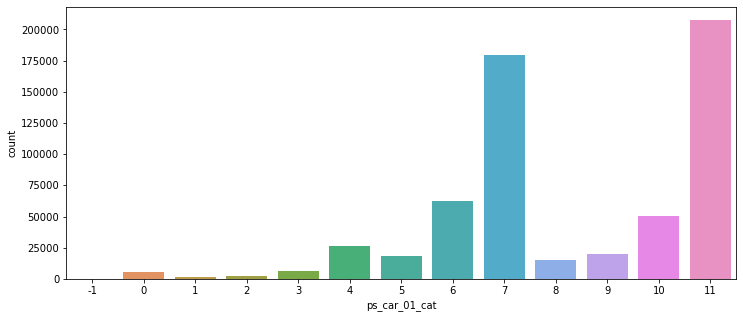

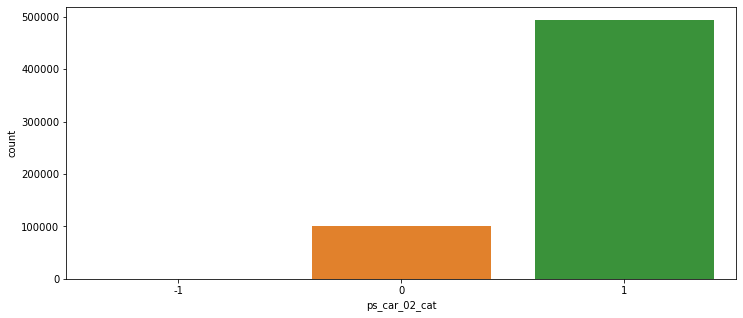

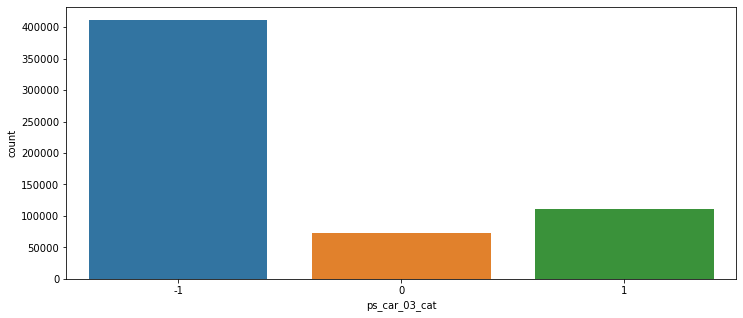

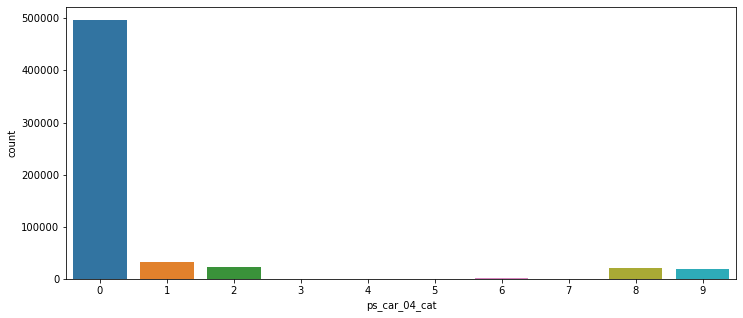

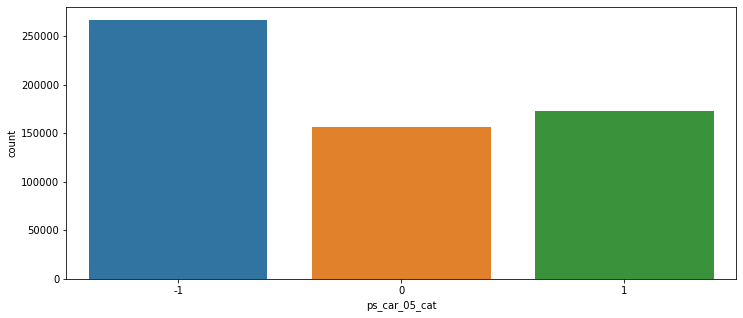

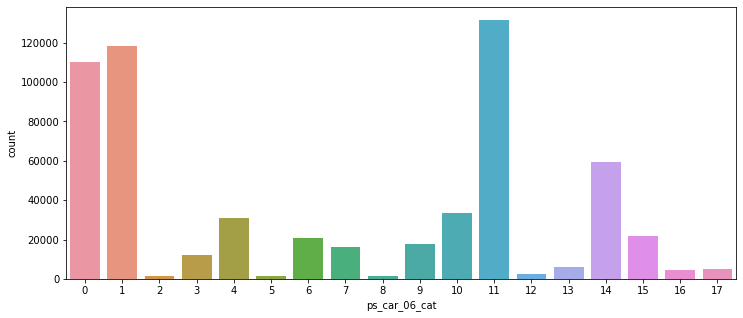

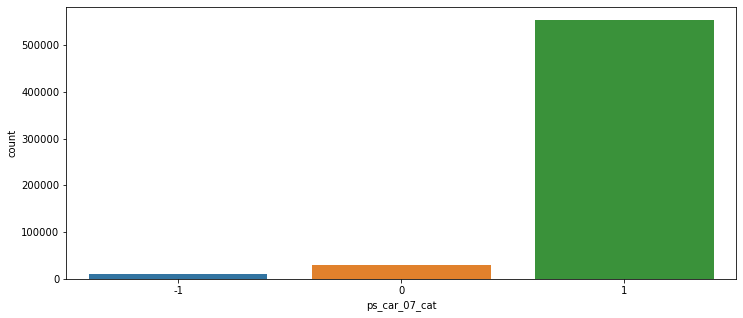

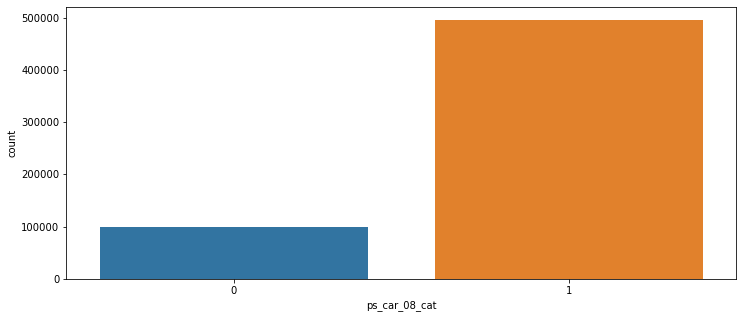

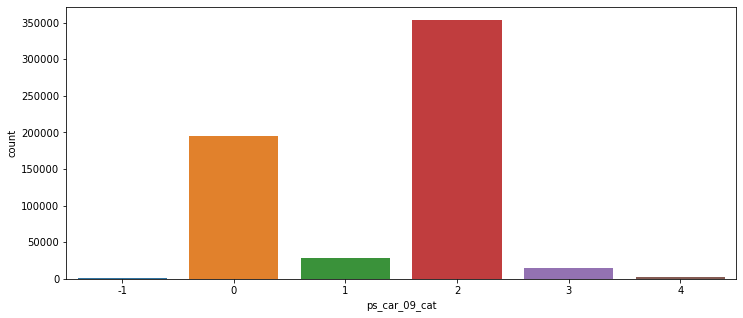

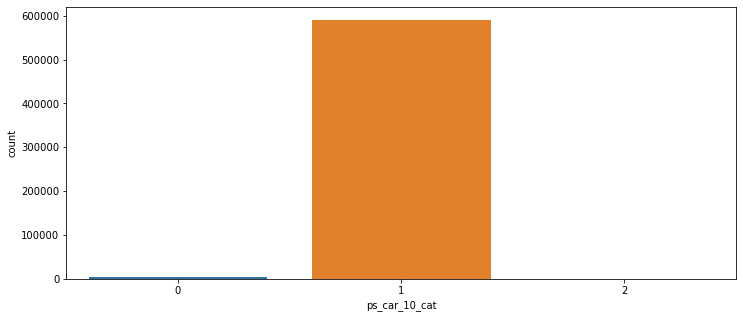

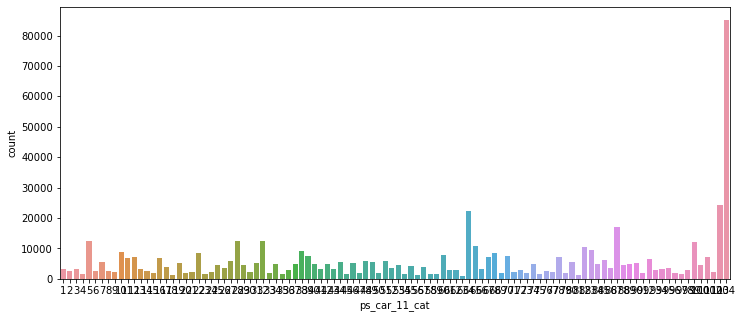

In [33]:
for col in cat_features:
    bar_plot(col, X)

<AxesSubplot:>

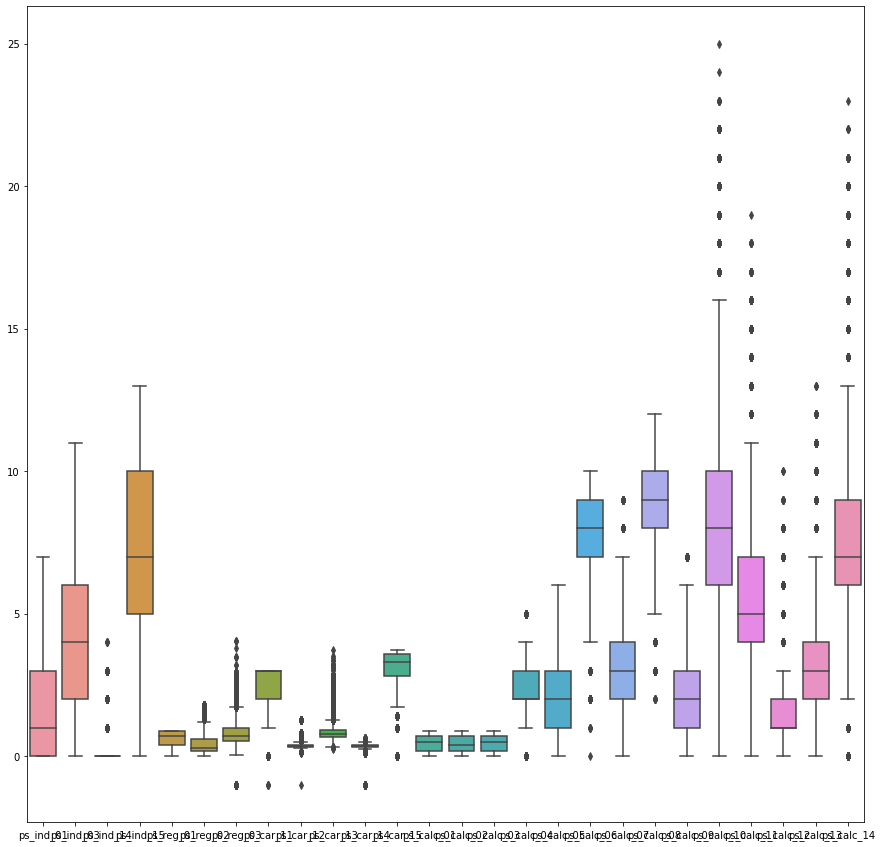

In [34]:
plt.figure(figsize=(15, 15))
sns.boxplot(data=X[cont_features])

In [35]:
def remove_outlier(df_in,y, col_name):
    for i in col_name:
        q1 = df_in[i].quantile(0.25)
        q3 = df_in[i].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_out = df_in.loc[(df_in[i] > fence_low) & (df_in[i] < fence_high)]
        y_out = y.loc[(df_in[i] > fence_low) & (df_in[i] < fence_high)]
    return df_out, y_out

In [113]:
X,y = remove_outlier(X,y, cont_features)

In [114]:
X.shape, y.shape

((428256, 57), (428256,))

In [116]:
y.value_counts()

0    414081
1     14175
Name: target, dtype: int64

In [117]:
from imblearn.under_sampling import TomekLinks 

In [118]:
#cc = ClusterCentroids(n_jobs = -1)
X_cc, y_cc = RandomOverSampler(sampling_strategy=0.2).fit_sample(X, y)
X_cc, y_cc = RandomUnderSampler().fit_sample(X_cc, y_cc)

In [119]:
X_cc.shape

(165632, 57)

In [120]:
y_cc.value_counts()

1    82816
0    82816
Name: target, dtype: int64

In [87]:
X_cc = StandardScaler().fit_transform(X_cc)

In [88]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
model = XGBClassifier()
model.fit(X_cc, y_cc)




[09:31:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

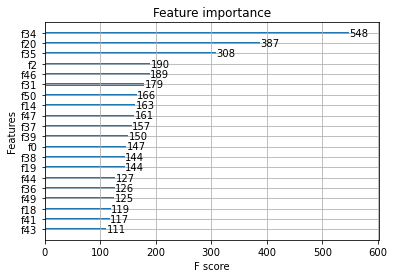

In [89]:
plot_importance(model, max_num_features= 20)

In [90]:
def gini_lgb(preds, dtrain):
    y = dtrain
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True    
    
def gini_lgb_train(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True     

In [91]:
thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
     # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_cc)

In [92]:
xgb_fea_imp=pd.DataFrame(list(model.get_booster().get_fscore().items()))

In [93]:
sorted_fea = sorted(model.get_booster().get_fscore().items(), key=lambda kv: kv[1])

In [94]:
list_features = sorted_fea[-35:]

In [95]:
x_train, x_test, y_train, y_test = train_test_split(X_cc, y_cc, test_size=0.3, random_state=42)

In [96]:
# не надо
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

In [237]:
params_grid ={
    'learning_rate' : np.arange(0.1,1,10),
 "max_depth"        : range(3,10),
 "min_child_weight" : np.arange(0.1,1,10),
 "gamma"            : [ 0.05,0.3,20 ],          
 "colsample_bytree" : np.arange(0.05,1,20) }


In [238]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

In [239]:
xgb = XGBClassifier(   n_estimators =100,
                    objective='binary:logistic', eval_metric = 'auc')

In [240]:
random_search = RandomizedSearchCV(xgb,
                                   param_distributions=params_grid,
                                   n_iter=1000,
                                   cv =5,
                                   verbose= 10,
                                   #scoring=gini_lgb_train,
                                   scoring='roc_auc',
                                   n_jobs=-1,
                                   random_state=1863 )

In [241]:

random_search.fit(x_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='auc', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [242]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.05, eval_metric='auc',
              gamma=0.05, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=9, min_child_weight=0.1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [243]:
y_pred = random_search.predict_proba(x_test)[:, 1]

In [244]:
gini_normalized(y_test, y_pred)

0.3039959398745887

In [245]:
res_pred = random_search.predict_proba( insurance_data_test)[:, 1]

In [247]:
porto_res = pd.DataFrame({'id':sample_submission.index, 'target': res_pred})
porto_res.to_csv(path_or_buf=os.path.join(PATH, 'porto','porto_pred.csv'), header =True,index=False, encoding = "ISO-8859-1")



In [248]:
# На какгле максимальный скор был 0.15, но я ту модель потерял 
# эта переодучена, на кагле 0.09